This is an exploratory notebook for the modeling of dog breed recognition

In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from helper_functions import (clustering, find_cluster, image_preprocessing,
                              top_k_accuracy, learning_curve)
from scipy.io import loadmat
from xml.dom import minidom

import pdb 
import seaborn as sns
sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/pmlee/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'imread', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#some flags
crossval = False

# Load data

In [3]:
train_list = loadmat('./lists/train_list.mat')
test_list = loadmat('./lists/test_list.mat')

In [4]:
import re

def find_dogbreed(file_str, delimiter="-|/"):
    return re.split("-|/",file_str)[1]

In [5]:
file_list_train = [entry.item() for entry in train_list["file_list"].flatten()]
label_list_train = [entry.item() for entry in train_list["labels"]]
annot_list_train = [entry.item() for entry in train_list['annotation_list'].flatten()]

In [6]:
df_train = pd.DataFrame(
    list(zip(label_list_train, file_list_train, annot_list_train)),
    columns=["LABELS", "PATH", "ANNOTATION"])
df_train["BREED"] = df_train.PATH.apply(find_dogbreed)
df_y_train = pd.get_dummies(df_train.LABELS)

In [7]:
df_train.sample(10, random_state=42)

LABELS                                               PATH  \
1935      20       n02090721-Irish_wolfhound/n02090721_3398.jpg   
6494      65      n02101388-Brittany_spaniel/n02101388_2522.jpg   
1720      18                 n02090379-redbone/n02090379_91.jpg   
9120      92                 n02108089-boxer/n02108089_4865.jpg   
360        4             n02086079-Pekinese/n02086079_21103.jpg   
9663      97        n02109525-Saint_Bernard/n02109525_16100.jpg   
5277      53  n02098286-West_Highland_white_terrier/n0209828...   
8546      86             n02107142-Doberman/n02107142_11757.jpg   
2221      23          n02091244-Ibizan_hound/n02091244_2871.jpg   
4617      47       n02097130-giant_schnauzer/n02097130_3385.jpg   

                                             ANNOTATION  \
1935           n02090721-Irish_wolfhound/n02090721_3398   
6494          n02101388-Brittany_spaniel/n02101388_2522   
1720                     n02090379-redbone/n02090379_91   
9120                     n02108089-boxer/n02108089_4865   
360                  n02086079-Pekinese/n02086079_21103   
9663            n02109525-Saint_Bernard/n02109525_16100   
5277  n02098286-West_Highland_white_terrier/n0209828...   
8546                 n02107142-Doberman/n02107142_11757   
2221              n02091244-Ibizan_hound/n02091244_2871   
4617           n02097130-giant_schnauzer/n02097130_3385   

                            BREED  
1935              Irish_wolfhound  
6494             Brittany_spaniel  
1720                      redbone  
9120                        boxer  
360                      Pekinese  
9663                Saint_Bernard  
5277  West_Highland_white_terrier  
8546                     Doberman  
2221                 Ibizan_hound  
4617              giant_schnauzer

In [8]:
def img_cropping(parsedXML, img):
    xmin = int(parsedXML.getElementsByTagName('xmin')[0].firstChild.nodeValue)
    ymin = int(parsedXML.getElementsByTagName('ymin')[0].firstChild.nodeValue)
    xmax = int(parsedXML.getElementsByTagName('xmax')[0].firstChild.nodeValue)
    ymax = int(parsedXML.getElementsByTagName('ymax')[0].firstChild.nodeValue)
    
    cropped = img[xmin:xmax,ymin:ymax]
    return cropped

In [9]:
file_list_test = [entry.item() for entry in test_list["file_list"].flatten()]
label_list_test = [entry.item() for entry in test_list["labels"]]
annot_list_test = [entry.item() for entry in test_list['annotation_list'].flatten()]

In [10]:
df_test = pd.DataFrame(
    list(zip(label_list_test, file_list_test, annot_list_test)),
    columns=["LABELS", "PATH", "ANNOTATION"])
df_test["BREED"] = df_test.PATH.apply(find_dogbreed)
df_y_test = pd.get_dummies(df_test.LABELS)

In [11]:
df_test.sample(10, random_state=42)

LABELS                                           PATH  \
4951      66           n02101556-clumber/n02101556_2362.jpg   
4825      64      n02101006-Gordon_setter/n02101006_772.jpg   
6740      97     n02109525-Saint_Bernard/n02109525_6693.jpg   
222        3       n02085936-Maltese_dog/n02085936_1155.jpg   
5746      81           n02106030-collie/n02106030_17285.jpg   
6969     100   n02110185-Siberian_husky/n02110185_13197.jpg   
1084      12            n02088364-beagle/n02088364_6211.jpg   
2758      35   n02094114-Norfolk_terrier/n02094114_2823.jpg   
6458      91       n02108000-EntleBucher/n02108000_1468.jpg   
3459      43  n02096294-Australian_terrier/n02096294_73.jpg   

                                     ANNOTATION               BREED  
4951           n02101556-clumber/n02101556_2362             clumber  
4825      n02101006-Gordon_setter/n02101006_772       Gordon_setter  
6740     n02109525-Saint_Bernard/n02109525_6693       Saint_Bernard  
222        n02085936-Maltese_dog/n02085936_1155         Maltese_dog  
5746           n02106030-collie/n02106030_17285              collie  
6969   n02110185-Siberian_husky/n02110185_13197      Siberian_husky  
1084            n02088364-beagle/n02088364_6211              beagle  
2758   n02094114-Norfolk_terrier/n02094114_2823     Norfolk_terrier  
6458       n02108000-EntleBucher/n02108000_1468         EntleBucher  
3459  n02096294-Australian_terrier/n02096294_73  Australian_terrier

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


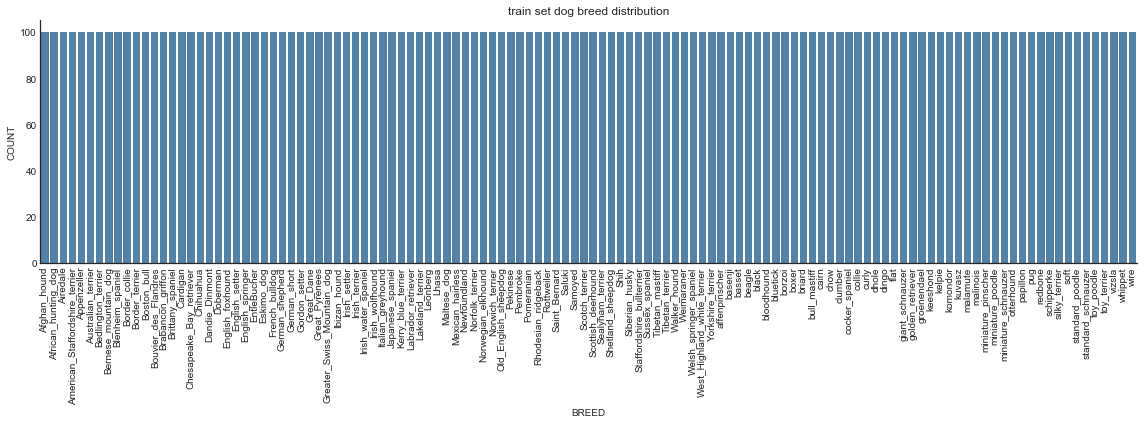

In [12]:
# Sanity check: plot train set distribution 
df_train_count = df_train.groupby('BREED').agg('count')["LABELS"]
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(df_train_count.index, df_train_count, color="steelblue")
ax.set_ylabel("COUNT")
ax.set_xticklabels(df_train_count.index,rotation=90)
sns.despine()
ax.set_title("train set dog breed distribution")
plt.tight_layout()

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


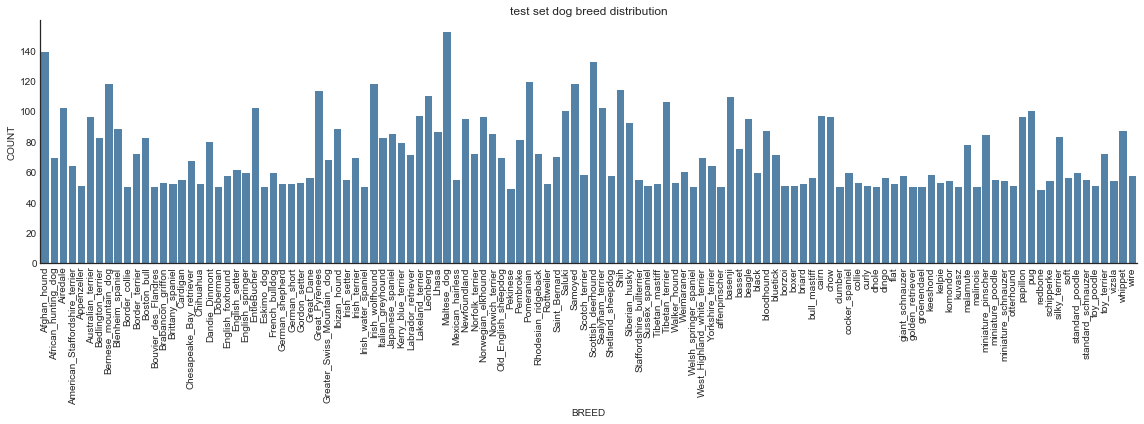

In [13]:
# Sanity check: plot train set distribution 
df_test_count = df_test.groupby('BREED').agg('count')["LABELS"]
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(df_test_count.index, df_test_count, color="steelblue")
ax.set_ylabel("COUNT")
ax.set_xticklabels(df_test_count.index,rotation=90)
sns.despine()
ax.set_title("test set dog breed distribution")
plt.tight_layout()

__Observation:__
- Distribution of dog breed in the training set is uniform
- Distribution of dog breed in the test set is not uniform

# Example of HOG + Daisy + SIFT features

/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


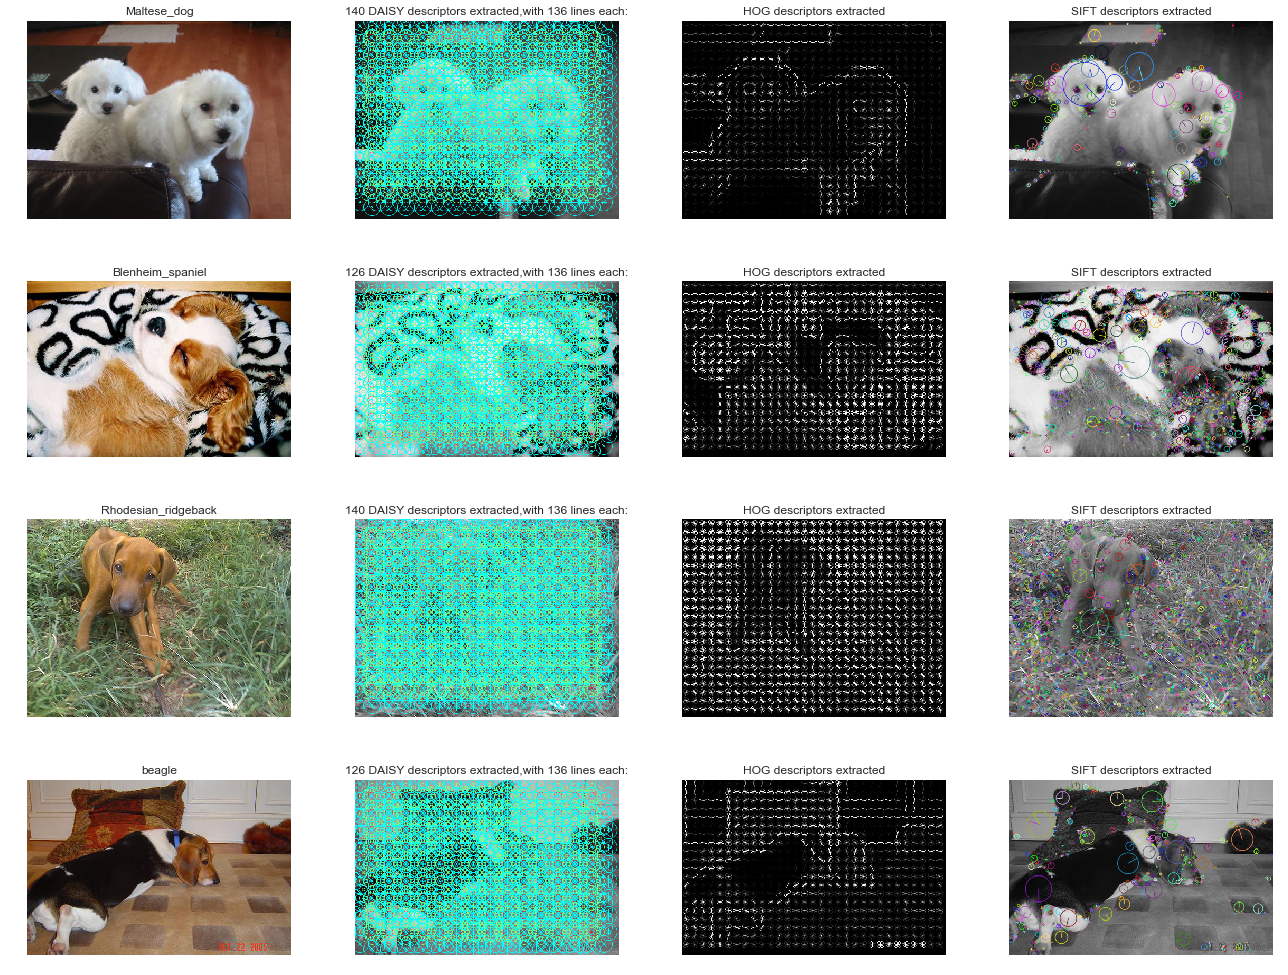

In [14]:
from skimage import exposure
from skimage.io import imread

index_image = [260, 567, 862,1193]
descs_daisy = [[] for i in range(len(index_image))]
descs_hog = [[] for i in range(len(index_image))]
images_hog = [[] for i in range(len(index_image))]
images_daisy = [[] for i in range(len(index_image))]
images = [[] for i in range(len(index_image))]
descs_SIFT = [[] for i in range(len(index_image))]
images_SIFT = [[] for i in range(len(index_image))]

for i, key in enumerate(index_image):
    images[i] = imread("./images/" + df_train.loc[key].PATH)
    #parsedXML = minidom.parse("./Annotation/"+ df_train.loc[key].ANNOTATION)
    #images[i] = img_cropping(parsedXML, img)
    output = image_preprocessing(images[i], visualize=True)
    descs_hog[i] = output[0][0]
    images_hog[i] = output[0][1]
    descs_daisy[i] = output[1][0]
    images_daisy[i] = output[1][1]
    descs_SIFT[i] = output[2][0]
    images_SIFT[i] = output[2][1]
    
fig, axes = plt.subplots(4, 4, figsize=(18, 14))
j = 0

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')

    if i % 4 == 0:
        ax.imshow(images[j])
        ax.set_title(df_train.loc[index_image[j]].BREED)
    elif i % 4 == 1:
        ax.imshow(images_daisy[j])
        descs_num = descs_daisy[j].shape[0] * descs_daisy[j].shape[1]
        ax.set_title('%i DAISY descriptors extracted,with %d lines each:' %
                     (descs_num, descs_daisy[j].shape[2]))
    elif i % 4 == 2:
        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(images_hog[j], 
                                                        in_range = (0,10))
        ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax.set_title('HOG descriptors extracted')
    elif i % 4 == 3:
        ax.imshow(images_SIFT[j])
        ax.set_title('SIFT descriptors extracted')
        # incrementation
        j += 1
plt.tight_layout()

## BOVW representation
Perform clustering on Daisy features to form a dictionary. A histogram feature (daisy histogram) corresponding to each feature of k-dimensions, k is to be determined.

### Train/test set preparation

In [15]:
from numpy.random import seed, shuffle

# train set
seed(12)
size_train = len(df_train)
n_class_temp = numpy.arange(120)
shuffle(n_class_temp)
n_class = n_class_temp[:20]
n_class_init = 120
init_n_train = size_train/n_class_init # don't change
n_train = [20, 40, 60, 80, 100] # train per class
index_train_samples = [[] for i in range(len(n_train))]

for j in range(len(n_train)):
    # train set indices
    for i in n_class:
        index_train_temp = np.arange((i-1) * init_n_train, i * init_n_train , dtype=int)
        np.random.seed(2)
        np.random.shuffle(index_train_temp)
        index_train_samples[j].extend(index_train_temp[:n_train[j]])
        
# test set indices
n_test_overall = len(index_train_samples[4])#int(.8*len(index_train_samples[0]))
index_test_temp = list(df_test[df_test.LABELS.isin(n_class)].index)
#index_test_temp = list(df_test.filter(items=n_class, axis=1).index)
np.random.shuffle(index_test_temp)
index_test_samples = index_test_temp[:n_test_overall]

## Sanity check
Random sampling of each breed.

__Train set__

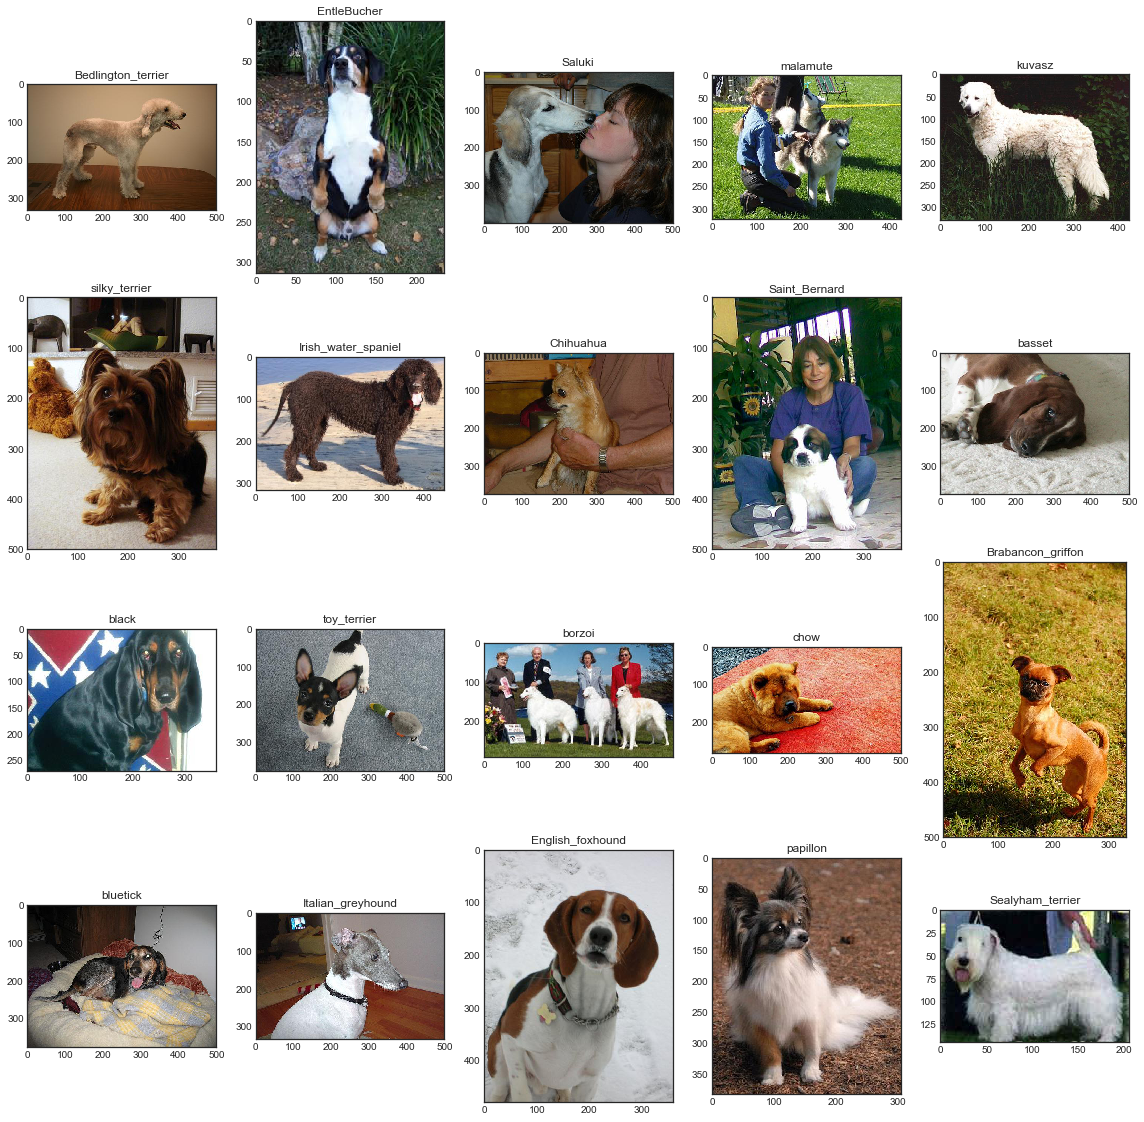

In [16]:
dog_breed = df_train.loc[index_train_samples[0]].drop_duplicates(subset="BREED")
fig, axes = plt.subplots(4,5, figsize=(16,16))
ax = axes.flatten()
counter = 0

for _ , breed in dog_breed.iterrows():
    dog_img = imread("./images/" + breed.PATH)
    #parsedXML = minidom.parse("./Annotation/"+ breed.ANNOTATION)
    #cropped_image = img_cropping(parsedXML, dog_img)
    ax[counter].imshow(dog_img)
    ax[counter].set_title(breed.BREED)
    counter += 1

plt.tight_layout()

__Test set__

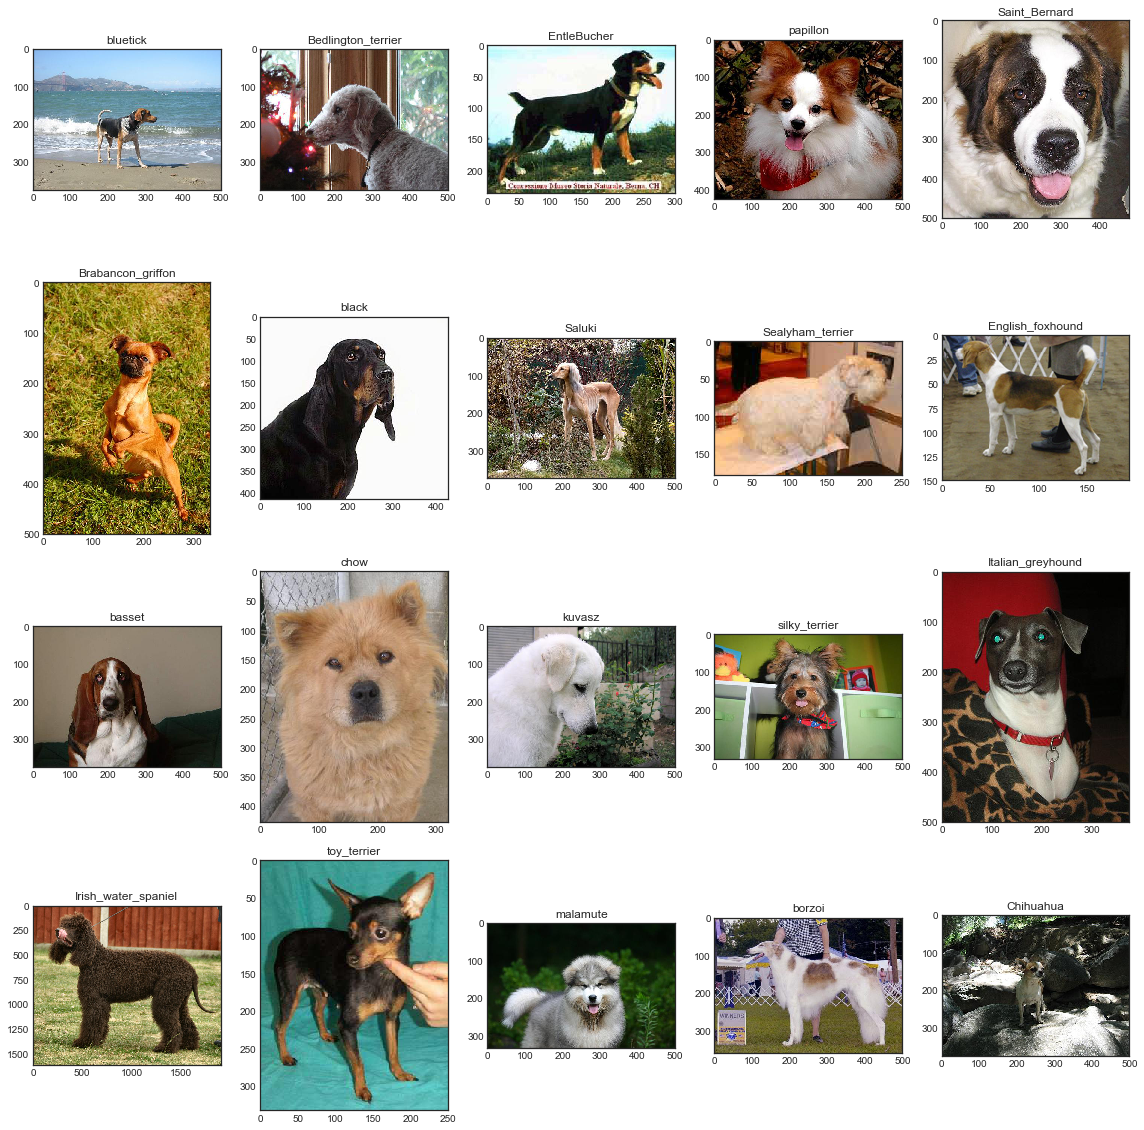

In [17]:
dog_breed_test = df_test.loc[index_test_samples].drop_duplicates(subset="BREED")
fig, axes = plt.subplots(4,5, figsize=(16,16))
ax = axes.flatten()
counter = 0

for _ , breed in dog_breed_test.iterrows():
    dog_img = imread("./images/" + breed.PATH)
    ax[counter].imshow(dog_img)
    ax[counter].set_title(breed.BREED)
    counter += 1

plt.tight_layout()

__Observation__:
- Selected dog breeds are rather distinct

# Feature Engineering

In [18]:
hog_feat_list = [[] for i in range(len(n_train))]
daisy_feat_list = [[] for i in range(len(n_train))]
sift_feat_list = [[] for i in range(len(n_train))]
y_train = [[] for i in range(len(n_train))]
train_features = [defaultdict(list) for i in range(len(n_train))]
test_features = defaultdict(list)

print("Feature engineering for the train set...")

for j in range(len(n_train)):
    for i, key in tqdm(enumerate(index_train_samples[j])):
        img = Image.open("./images/" + df_train.loc[key].PATH)
        output_features = image_preprocessing(img)
        train_features[j][key] = output_features
        hog_feat_list[j] = hog_feat_list[j] + list(output_features[0])
        daisy_feat_list[j] = daisy_feat_list[j] + list(output_features[1])
        sift_feat_list[j] = sift_feat_list[j] + list(output_features[2])

    print('Total Daisy descriptors (train):', len(daisy_feat_list[j]))
    print('Total SIFT descriptors (train):', len(sift_feat_list[j]))
    print('Total HOG descriptors (train):', len(hog_feat_list[j]))
    
    y_train[j] = df_train.loc[index_train_samples[j]].LABELS

#test set
print("Feature engineering for the test set...")
for i, key in tqdm(enumerate(index_test_samples)):
    img = Image.open("./images/" + df_test.loc[key].PATH)
    output_features = image_preprocessing(img)
    test_features[key] = output_features

y_test = df_test.loc[index_test_samples].LABELS

0it [00:00, ?it/s]

Feature engineering for the train set...


/Users/pmlee/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
400it [13:12,  1.98s/it]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 52659
Total SIFT descriptors (train): 454117
Total HOG descriptors (train): 2106560


800it [26:15,  1.97s/it]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 103797
Total SIFT descriptors (train): 871293
Total HOG descriptors (train): 4156104


1200it [42:17,  2.11s/it]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 164874
Total SIFT descriptors (train): 1321047
Total HOG descriptors (train): 6536104


1600it [58:11,  2.18s/it]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 219164
Total SIFT descriptors (train): 1749139
Total HOG descriptors (train): 8692160


2000it [1:13:49,  2.21s/it]
0it [00:00, ?it/s]

Total Daisy descriptors (train): 275425
Total SIFT descriptors (train): 2211286
Total HOG descriptors (train): 10906656
Feature engineering for the test set...


1481it [31:30,  1.28s/it]


# Model Training
## Using only SIFT descriptors
### Study of performance vs number of samples
We limit our study to only 20 classes to curtail calculation. Logistic regression is used as the model to have a ballpark estimate of the performance. The number of clusters for daisy descriptors is fixed to 1000, will be fine tuned in the following studies.

In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

# we fix the cluster number to 1000, will be fine tuned in the following
# studies

k_sift = 1000
train_scores = [[] for i in range(len(n_train))]
test_scores = [[] for i in range(len(n_train))]
parameters = {'C': np.logspace(-3, 3, 7)}

for j in range(len(n_train)):

    print('Total SIFT descriptors (train):', len(sift_feat_list[j]))

    X_train = []
    X_test = []

    print("Processing k=%d" % k_sift)
    kmeans = clustering(sift_feat_list[j], k_sift)

    for key, features in train_features[j].items():
        bovw_feature = find_cluster(kmeans, features[2])
        X_train.append(bovw_feature)

    for key, features in test_features.items():
        bovw_feature_test = find_cluster(kmeans, features[2])
        X_test.append(bovw_feature_test)

    print("Training...")
   
    svc = LinearSVC(multi_class="ovr")
    clf = GridSearchCV(svc, parameters, scoring='accuracy')
    #clf = OneVsRestClassifier(LogisticRegressionCV(dual=False))
    #clf = OneVsRestClassifier(CalibratedClassifierCV(SVC(C=1)))
    clf.fit(X_train, y_train[j])
    #print("(CV) Best score:", clf.best_score_)
    #print("(CV) Mode best C:", clf.best_estimator_.C)

    print("Prediction...")
    y_pred_train = clf.predict(np.array(X_train))
    y_pred_test = clf.predict(np.array(X_test))
    train_score = accuracy_score(y_train[j], y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)
    print('Overall accuracy (train):', train_score)
    print('Overall accuracy (test):', test_score)
    train_scores[j] = train_score
    test_scores[j] = test_score

Total SIFT descriptors (train): 454117
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.67
Overall accuracy (test): 0.16205266711681296
Total SIFT descriptors (train): 871293
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.85125
Overall accuracy (test): 0.22214719783929776
Total SIFT descriptors (train): 1321047
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.9933333333333333
Overall accuracy (test): 0.2187711006076975
Total SIFT descriptors (train): 1749139
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.76625
Overall accuracy (test): 0.24645509790681971
Total SIFT descriptors (train): 2211286
Processing k=1000
Training...
Prediction...
Overall accuracy (train): 0.728
Overall accuracy (test): 0.27076299797434167


In [20]:
df_n_samples = pd.DataFrame(list(zip(n_train,train_scores,test_scores)), columns=["SAMPLES","TRAIN", "TEST"])

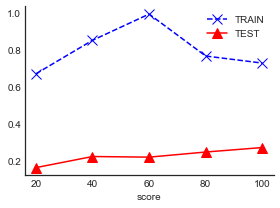

In [21]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df_n_samples.SAMPLES, df_n_samples.TRAIN, marker="x", markersize=10, 
        label="TRAIN", linestyle = "--", color="blue")
ax.plot(df_n_samples.SAMPLES, df_n_samples.TEST, marker="^", markersize=10, 
        label="TEST", linestyle = "solid", color="red")
ax.legend(loc='best')
ax.set_xlabel("# samples")
ax.set_xlabel("score")
sns.despine()
plt.tight_layout()

__Observation__:
- We observe a tendency of the gap closing between the train score and the test score, however the number of training samples is not high enough to close the gap. More samples per class are needed to be able to improve the performance.
- We retain here 100 samples per class, and with a regularisation term C=0.1.

### Determing the optimal number of clusters for SIFT descriptors

In [22]:
from sklearn.model_selection import KFold

C = 0.1
index_op_sample = 4
n_splits = 3
train_features_c = train_features[index_op_sample]
y_train_c = df_train.loc[index_train_samples[index_op_sample]].LABELS
n_clusters = np.logspace(2, 3.5, 6, dtype=int32)
train_scores_clusters = [[] for i in range(len(n_clusters))]
test_scores_clusters = [[] for i in range(len(n_clusters))]
cv_scores_clusters = [[]for i in range(len(n_clusters))]

for j, k in enumerate(n_clusters):
    # training set
    X_train = []
    X_test = []
    
    print("Processing k=%d" %k )
    kmeans = clustering(sift_feat_list[index_op_sample], k)

    for key, features in train_features_c.items():
        bovw_feature = find_cluster(kmeans, features[2])
        X_train.append(bovw_feature)

    for key, features in test_features.items():
        bovw_feature_test = find_cluster(kmeans, features[2])
        X_test.append(bovw_feature_test)
    
    print("Training (Cross Validation)...")
    clf = LinearSVC(multi_class="ovr", C=C)
    
    kf = KFold(n_splits=n_splits)
    X_temp = np.array(X_train)
    y_temp = np.array(y_train_c)

    for train_index, test_index in kf.split(X_temp):
        clf.fit(X_temp[train_index,:], y_temp[train_index])

        # training
        y_train_pred = clf.predict(X_temp[train_index,:])
        train_scores_clusters[j].append(accuracy_score(y_temp[train_index], y_train_pred))

        # cross validation
        y_cv_pred = clf.predict(X_temp[test_index,:])
        cv_scores_clusters[j].append(accuracy_score(y_temp[test_index], y_cv_pred))

        # test
        y_test_pred = clf.predict(np.array(X_test))
        test_scores_clusters[j].append(accuracy_score(y_test, y_test_pred))

    train_score = np.mean(train_scores_clusters[j])
    test_score = np.mean(test_scores_clusters[j])
    
    print('Overall accuracy (train):', train_score)
    print('Overall accuracy (test):', test_score)

Processing k=100
Training (Cross Validation)...
Overall accuracy (train): 0.3672490461445946
Overall accuracy (test): 0.17578212919198735
Processing k=199
Training (Cross Validation)...
Overall accuracy (train): 0.4649998706573195
Overall accuracy (test): 0.19153724960612198
Processing k=398
Training (Cross Validation)...
Overall accuracy (train): 0.5547462577788376
Overall accuracy (test): 0.2086428089128967
Processing k=794
Training (Cross Validation)...
Overall accuracy (train): 0.6925005239315826
Overall accuracy (test): 0.203691199639883
Processing k=1584
Training (Cross Validation)...
Overall accuracy (train): 0.8265017903651325
Overall accuracy (test): 0.21674544226873735
Processing k=3162
Training (Cross Validation)...
Overall accuracy (train): 0.9094985515494316
Overall accuracy (test): 0.21381949133468378


In [26]:
def learning_curve(n_clusters, train_scores, test_scores, ax):
    """
    plot learning curve

    Parameters:
    -----------
    train_scores: array_like
        train_scores
    test_scores: array_like
        test_scores
    ax: plt axis object
        plotting axis

    Returns:
    --------
    ax: plt axis object
    """

    train_scores_mean = np.array([np.mean(v) for v in train_scores])
    train_scores_std = np.array([np.std(v) for v in train_scores])
    test_scores_mean = np.array([np.mean(v) for v in test_scores])
    test_scores_std = np.array([np.std(v) for v in test_scores])
    #cv_scores_mean = np.array([np.mean(v) for v in cv_scores])
    #cv_scores_std = np.array([np.std(v) for v in cv_scores])

    ax.fill_between(n_clusters, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    #ax.fill_between(n_clusters, cv_scores_mean - cv_scores_std,
    #                     cv_scores_mean + cv_scores_std, alpha=0.1, color="g")
    ax.fill_between(n_clusters, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax.plot(n_clusters, train_scores_mean, 'o-', color="r", label="Training")
    #ax.plot(n_clusters, cv_scores_mean, 'o-', color="g",
    #             label="Cross-validation")
    ax.plot(n_clusters, test_scores_mean, 'o-', color="b", label="Test")

    ax.legend(loc='best')

    ax.set_xlabel("# clusters")
    ax.set_ylabel("Score")

    return ax


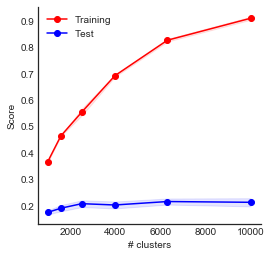

In [85]:
# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax = learning_curve(n_clusters, train_scores_clusters, test_scores_clusters, ax)
sns.despine()

__Observation__:
- From cluster number>800 onwards, the test score is relatively stable, can be estimated useing the elbow method as well. So we choose cluster number = 800.

In [83]:
df_n_clusters = pd.DataFrame(
    list(zip(n_clusters, np.mean(train_scores_clusters, axis=1),
            np.mean(test_scores_clusters, axis=1))),
    columns=["# CLUSTER", "TRAIN", "TEST"])
df_n_clusters

# CLUSTER     TRAIN      TEST
0       1000  0.367249  0.175782
1       1584  0.465000  0.191537
2       2511  0.554746  0.208643
3       3981  0.692501  0.203691
4       6309  0.826502  0.216745
5      10000  0.909499  0.213819

## Using Daisy descriptors only
### Determining the right number of clusters for Daisy descriptors

In [29]:
train_scores_clusters_daisy = [[] for i in range(len(n_clusters))]
test_scores_clusters_daisy = [[] for i in range(len(n_clusters))]
cv_scores_clusters_daisy = [[]for i in range(len(n_clusters))]
        
for j, k in enumerate(n_clusters):
    # training set
    X_train = []
    X_test = []
    
    print("Processing k=%d" %k )
    kmeans = clustering(daisy_feat_list[index_op_sample], k)

    for key, features in train_features_c.items():
        bovw_feature = find_cluster(kmeans, features[1])
        X_train.append(bovw_feature)

    for key, features in test_features.items():
        bovw_feature_test = find_cluster(kmeans, features[1])
        X_test.append(bovw_feature_test)
    
    print("Training (Cross Validation)...")
    clf = LinearSVC(multi_class="ovr", C=C)
    
    kf = KFold(n_splits=n_splits)
    X_temp = np.array(X_train)
    y_temp = np.array(y_train_c)

    for train_index, test_index in kf.split(X_temp):
        clf.fit(X_temp[train_index,:], y_temp[train_index])

        # training
        y_train_pred = clf.predict(X_temp[train_index,:])
        train_scores_clusters_daisy[j].append(accuracy_score(y_temp[train_index], y_train_pred))

        # cross validation
        y_cv_pred = clf.predict(X_temp[test_index,:])
        cv_scores_clusters_daisy[j].append(accuracy_score(y_temp[test_index], y_cv_pred))

        # test
        y_test_pred = clf.predict(np.array(X_test))
        test_scores_clusters_daisy[j].append(accuracy_score(y_test, y_test_pred))

    train_score = np.mean(train_scores_clusters_daisy[j])
    test_score = np.mean(test_scores_clusters_daisy[j])
    
    print('Overall accuracy (train):', train_score)
    print('Overall accuracy (test):', test_score)

Processing k=100
Training (Cross Validation)...
Overall accuracy (train): 0.3622494829104577
Overall accuracy (test): 0.1507990096781454
Processing k=199
Training (Cross Validation)...
Overall accuracy (train): 0.46549980823541715
Overall accuracy (test): 0.1485482781904119
Processing k=398
Training (Cross Validation)...
Overall accuracy (train): 0.6054986385276978
Overall accuracy (test): 0.179383299572361
Processing k=794
Training (Cross Validation)...
Overall accuracy (train): 0.7297487790238414
Overall accuracy (test): 0.18230925050641458
Processing k=1584
Training (Cross Validation)...
Overall accuracy (train): 0.8537524186143988
Overall accuracy (test): 0.18658564033310823
Processing k=3162
Training (Cross Validation)...
Overall accuracy (train): 0.9405001175331315
Overall accuracy (test): 0.18230925050641458


In [35]:
def learning_curve(n_clusters, train_scores, test_scores, ax):
    
    train_scores_mean = np.array([np.mean(v) for v in train_scores])
    train_scores_std = np.array([np.std(v) for v in train_scores])
    test_scores_mean = np.array([np.mean(v) for v in test_scores])
    test_scores_std = np.array([np.std(v) for v in test_scores])
    #cv_scores_mean = np.array([np.mean(v) for v in cv_scores])
    #cv_scores_std = np.array([np.std(v) for v in cv_scores])

    ax.fill_between(n_clusters, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    #ax.fill_between(n_clusters, cv_scores_mean - cv_scores_std,
    #                     cv_scores_mean + cv_scores_std, alpha=0.1, color="g")
    ax.fill_between(n_clusters, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax.plot(n_clusters, train_scores_mean, 'o-', color="r", label="Training")
    #ax.plot(n_clusters, cv_scores_mean, 'o-', color="g",
    #             label="Cross-validation")
    ax.plot(n_clusters, test_scores_mean, 'o-', color="b", label="Test")

    ax.legend(loc='best')

    ax.set_xlabel("# clusters")
    ax.set_ylabel("Score")
    
    return ax

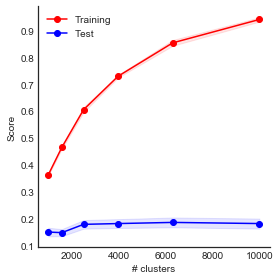

In [84]:
# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax = learning_curve(n_clusters, train_scores_clusters_daisy, test_scores_clusters_daisy, ax)
sns.despine()
plt.tight_layout()

In [37]:
df_n_clusters_daisy = pd.DataFrame(
    list(
        zip(n_clusters, np.mean(train_scores_clusters_daisy, axis=1),
            np.mean(test_scores_clusters_daisy, axis=1))),
    columns=["# CLUSTER", "TRAIN", "TEST"])
df_n_clusters_daisy

# CLUSTER     TRAIN      TEST
0        100  0.362249  0.150799
1        199  0.465500  0.148548
2        398  0.605499  0.179383
3        794  0.729749  0.182309
4       1584  0.853752  0.186586
5       3162  0.940500  0.182309

## Using HOG descriptors only
### Determining the right number of clusters for HOG descriptors

In [80]:
n_clusters = np.logspace(3, 4, 6, dtype=int32)
train_scores_clusters_hog = [[] for i in range(len(n_clusters))]
test_scores_clusters_hog = [[] for i in range(len(n_clusters))]
cv_scores_clusters_hog = [[]for i in range(len(n_clusters))]

for j, k in enumerate(n_clusters):
    # training set
    X_train = []
    X_test = []
    
    print("Processing k=%d" %k )
    kmeans = clustering(np.reshape(hog_feat_list[index_op_sample], (-1,1)), k)

    for key, features in train_features_c.items():
        bovw_feature = find_cluster(kmeans, features[0].reshape(-1,1))
        X_train.append(bovw_feature)

    for key, features in test_features.items():
        bovw_feature_test = find_cluster(kmeans, features[0].reshape(-1,1))
        X_test.append(bovw_feature_test)
    
    print("Training (Cross Validation)...")
    clf = LinearSVC(multi_class="ovr", C=C)
    
    kf = KFold(n_splits=n_splits)
    X_temp = np.array(X_train)
    y_temp = np.array(y_train_c)

    for train_index, test_index in kf.split(X_temp):
        clf.fit(X_temp[train_index,:], y_temp[train_index])

        # training
        y_train_pred = clf.predict(X_temp[train_index,:])
        train_scores_clusters_hog[j].append(accuracy_score(y_temp[train_index], y_train_pred))

        # cross validation
        y_cv_pred = clf.predict(X_temp[test_index,:])
        cv_scores_clusters_hog[j].append(accuracy_score(y_temp[test_index], y_cv_pred))

        # test
        y_test_pred = clf.predict(np.array(X_test))
        test_scores_clusters_hog[j].append(accuracy_score(y_test, y_test_pred))

    train_score = np.mean(train_scores_clusters_hog[j])
    test_score = np.mean(test_scores_clusters_hog[j])

    print('Overall accuracy (train):', train_score)
    print('Overall accuracy (test):', test_score)

Processing k=1000
Training (Cross Validation)...
Overall accuracy (train): 0.48500618407975304
Overall accuracy (test): 0.08957911321179383
Processing k=1584
Training (Cross Validation)...
Overall accuracy (train): 0.5950066977014118
Overall accuracy (test): 0.09227999099707405
Processing k=2511
Training (Cross Validation)...
Overall accuracy (train): 0.710254962541235
Overall accuracy (test): 0.10015755120414134
Processing k=3981
Training (Cross Validation)...
Overall accuracy (train): 0.8020033494130653
Overall accuracy (test): 0.09723160027008777
Processing k=6309
Training (Cross Validation)...
Overall accuracy (train): 0.846249605879731
Overall accuracy (test): 0.09588116137744768
Processing k=10000
Training (Cross Validation)...
Overall accuracy (train): 0.8784967981125716
Overall accuracy (test): 0.09993247805536798


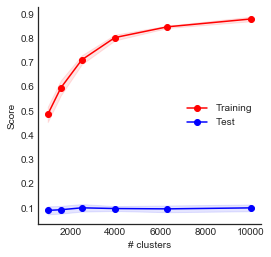

In [86]:
# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax = learning_curve(n_clusters, train_scores_clusters_hog, test_scores_clusters_hog, ax)
sns.despine()

In [82]:
df_n_clusters_hog = pd.DataFrame(
    list(
        zip(n_clusters,
            np.mean(train_scores_clusters_hog, axis=1),
            np.mean(test_scores_clusters_hog, axis=1))),
    columns=["# CLUSTER", "TRAIN", "TEST"])
df_n_clusters_hog

# CLUSTER     TRAIN      TEST
0       1000  0.485006  0.089579
1       1584  0.595007  0.092280
2       2511  0.710255  0.100158
3       3981  0.802003  0.097232
4       6309  0.846250  0.095881
5      10000  0.878497  0.099932

## Combination of SIFT + DAISY + HOG descriptors

In [40]:
k_sift = k_daisy = 800 # number of clusters
k_hog = 2500 # number of clusters
parameters = {'C': np.logspace(-3, 3, 7)}
X_train = []
X_test = []

# Clustering
kmeans_hog = clustering(np.reshape(hog_feat_list[index_op_sample], (-1,1)), k_hog)
kmeans_sift = clustering(sift_feat_list[index_op_sample], k_sift)
kmeans_daisy = clustering(daisy_feat_list[index_op_sample], k_daisy)
for key, features in train_features_c.items():
    bovw_feature_hog = find_cluster(kmeans_hog, np.reshape(features[0],(-1,1)))
    bovw_feature_daisy = find_cluster(kmeans_daisy, features[1])
    bovw_feature_sift = find_cluster(kmeans_sift, features[2])
    bovw_feature = bovw_feature_sift + bovw_feature_daisy + bovw_feature_hog
    X_train.append(bovw_feature)

for key, features in test_features.items():
    bovw_feature_hog = find_cluster(kmeans_hog,  np.reshape(features[0],(-1,1)))
    bovw_feature_daisy = find_cluster(kmeans_daisy, features[1])
    bovw_feature_sift = find_cluster(kmeans_sift, features[2])
    bovw_feature = bovw_feature_sift + bovw_feature_daisy + bovw_feature_hog
    X_test.append(bovw_feature)
    
print("Training (Cross Validation)...")

if crossval:
    svc =  LinearSVC(multi_class="ovr")
    clf_svm = GridSearchCV(svc, parameters, scoring='accuracy')
else:
    clf_svm =  LinearSVC(multi_class="ovr", C=0.1)
    
clf_svm.fit(X_train, y_train_c)

print("Prediction...")
y_pred_train = clf_svm.predict(np.array(X_train))
y_pred_test = clf_svm.predict(np.array(X_test))
train_score_svm = accuracy_score(y_train_c, y_pred_train)
test_score_svm = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_svm)
print('Overall accuracy (test):', test_score_svm)

Prediction...
Overall accuracy (train): 0.959
Overall accuracy (test): 0.3193787981093856


In [53]:
# Save model
from sklearn.externals import joblib
import os
filename = os.getcwd() + '/db/lr_linear.sav'
joblib.dump(clf_svm, filename)

['/Users/pmlee/Documents/CAPGemini_OpenClassroom/OpenClassrooms_Patrick_Lee/Assignment6/db/lr_linear.sav']

## Analysis of misclassified test labels

In [41]:
df_test_samples = df_test.loc[index_test_samples]
df_test_samples['PRED'] = y_pred_test

label2breed = dict()
df_label_breed = df_test_samples[["LABELS","BREED"]].drop_duplicates()

for k,v in df_label_breed.iterrows():
    label2breed[v.LABELS] = v.BREED

In [42]:
from sklearn.metrics import confusion_matrix

breeds = np.unique(df_test_samples['BREED'].values)
y_test_breeds = [label2breed[i] for i in y_test]
y_pred_test_breeds = [label2breed[i] for i in y_pred_test]
cm = confusion_matrix(y_test_breeds, y_pred_test_breeds, labels=np.unique(breeds))

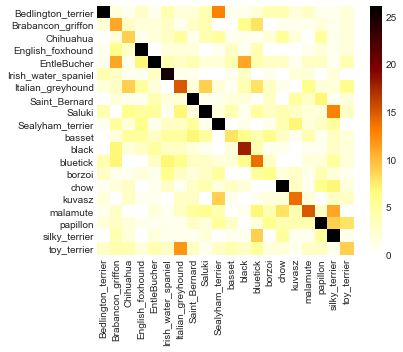

In [43]:
fig, ax = plt.subplots(figsize=(6, 5))
_ = sns.heatmap(
    cm,
    ax=ax,
    robust=True,
    cmap=plt.cm.afmhot_r,
    yticklabels=breeds,
    xticklabels=breeds)
plt.tight_layout()

In [44]:
j = 0
for k, v in df_test_samples.iterrows():
    df_test_samples.loc[k,'PRED_BREED']=label2breed[y_pred_test[j]]
    j+=1

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


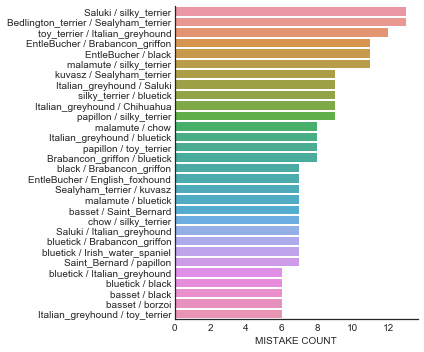

In [45]:
# misclass labels
misclass_df = df_test_samples[
    df_test_samples['BREED'] != df_test_samples['PRED_BREED']].groupby(
        ['BREED', 'PRED_BREED']).agg("count").sort_values(
            ['LABELS'], ascending=False).reset_index()
misclass_df['PAIR'] = misclass_df['BREED'] + ' / ' + misclass_df['PRED_BREED']
misclass_df = misclass_df[['PAIR', 'LABELS']].take(range(30))
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(y=misclass_df['PAIR'], x=misclass_df['LABELS'], ax=ax)
ax.set_yticklabels(misclass_df['PAIR'])
ax.set_xlabel("MISTAKE COUNT")
ax.set_ylabel("")

sns.despine()
plt.tight_layout()

## Other models

### Baseline model
DummyClassifier which classified the most frequent label

In [46]:
from sklearn.dummy import DummyClassifier

dummy = OneVsRestClassifier(DummyClassifier(strategy='prior'))
dummy.fit(X_train, y_train_c)

y_pred_train = dummy.predict(np.array(X_train))
y_pred_test = dummy.predict(np.array(X_test))
train_score_dummy = accuracy_score(y_train_c, y_pred_train)
test_score_dummy = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_dummy)
print('Overall accuracy (test):', test_score_dummy)

Overall accuracy (train): 0.05
Overall accuracy (test): 0.03578663065496286


### SVM with rbf kernel

In [47]:
from sklearn.svm import SVC

parameters = {'C': np.logspace(2, 7, 6)}

print("Training (Cross Validation)...")
if crossval:
    svc =  SVC(kernel='rbf', decision_function_shape="ovr")
    clf_svm_rbf = GridSearchCV(svc, parameters, scoring='accuracy')
else:
    clf_svm_rbf = SVC(C=1e5, kernel='rbf', decision_function_shape="ovr")

clf_svm_rbf.fit(X_train, y_train_c)

#print(clf_svm_rbf.best_params_)

print("Prediction...")
y_pred_train = clf_svm_rbf.predict(np.array(X_train))
y_pred_test = clf_svm_rbf.predict(np.array(X_test))
train_score_svm_rbf = accuracy_score(y_train_c, y_pred_train)
test_score_svm_rbf = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_svm_rbf)
print('Overall accuracy (test):', test_score_svm_rbf)

Training (Cross Validation)...
Prediction...
Overall accuracy (train): 1.0
Overall accuracy (test): 0.28831870357866307


### KNN classifier

In [48]:
from sklearn.neighbors import KNeighborsClassifier

params = {'estimator__n_neighbors' : np.arange(3,7)}
# classifier
if crossval:
    knn = OneVsRestClassifier(KNeighborsClassifier())
    clf_knn = GridSearchCV(knn, params, scoring='accuracy')
else:
    clf_knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=4))
    
clf_knn.fit(X_train, y_train_c)

#print(clf_knn.best_params_)

print("Prediction...")
y_pred_train = clf_knn.predict(np.array(X_train))
y_pred_test = clf_knn.predict(np.array(X_test))
train_score_knn = accuracy_score(y_train_c, y_pred_train)
test_score_knn = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_knn)
print('Overall accuracy (test):', test_score_knn)

Prediction...
Overall accuracy (train): 0.347
Overall accuracy (test): 0.12694125590817015


### LogisticRegression

In [49]:
from sklearn.linear_model import LogisticRegressionCV

Cs =np.logspace(-7, 6, 14)
clf_lr = LogisticRegressionCV(Cs=Cs, dual=False, multi_class= "ovr",
                               scoring="accuracy")
    
clf_lr.fit(X_train, y_train_c)

print(clf_lr.C_)

print("Prediction...")
y_pred_train = clf_lr.predict(np.array(X_train))
y_pred_test = clf_lr.predict(np.array(X_test))
train_score_lr = accuracy_score(y_train_c, y_pred_train)
test_score_lr = accuracy_score(y_test, y_pred_test)

print('Overall accuracy (train):', train_score_lr)
print('Overall accuracy (test):', test_score_lr)

[1.e+01 1.e+01 1.e-07 1.e+01 1.e+02 1.e+01 1.e+03 1.e-07 1.e+01 1.e+02
 1.e+05 1.e+02 1.e+01 1.e+05 1.e+06 1.e-07 1.e+01 1.e-07 1.e+01 1.e+01]
Prediction...
Overall accuracy (train): 0.8215
Overall accuracy (test): 0.27278865631330185


### Neural network
__NN-1__

In [79]:
from keras.models import load_model
import pickle
import h5py
from scipy.io import loadmat
dir_path = os.getcwd()
invertlabel2class = pickle.load(open(dir_path +'/db/invertlabel2class.p', "rb" ))
label2breed = pickle.load(open(dir_path + '/db/label2breed.p', "rb"))
model = load_model(dir_path + "/db/nn_model_base.h5")

model.summary()
print("Prediction...")
y_pred_train = model.predict(np.array(X_train))
y_pred_train_index = [np.argsort(i)[::-1][0] for i in y_pred_train]

y_pred_test = model.predict(np.array(X_test))
y_pred_test_index = [np.argsort(i)[::-1][0] for i in y_pred_test]

train_score_nn1 = accuracy_score(y_train_c, y_pred_train_index)
test_score_nn1 = accuracy_score(y_test, y_pred_test_index)

print('Overall accuracy (train):', train_score_nn1)
print('Overall accuracy (test):', test_score_nn1)

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow.python.training'

In [ ]:
model = load_model("/db/nn_model_2.h5")

model.summary()
print("Prediction...")
y_pred_train = model.predict(np.array(X_train))
y_pred_train_index = [invertlabel2class[np.argsort(i)[-1]] for i in y_pred_train]

y_pred_test = model.predict(np.array(X_test))
y_pred_test_index = [invertlabel2class[np.argsort(i)[-1]] for i in y_pred_test]

train_score_nn2 = accuracy_score(y_train_c, y_pred_train_index)
test_score_nn2 = accuracy_score(y_test, y_pred_test_index)

print('Overall accuracy (train):', train_score_nn2)
print('Overall accuracy (test):', test_score_nn2)

## Top k accuracy

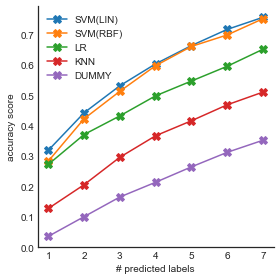

In [59]:
clf_list = [clf_svm, clf_svm_rbf, clf_lr, clf_knn, dummy]
clf_labels = ["SVM(LIN)", "SVM(RBF)", "LR", "KNN", "DUMMY", "NN-1", "NN-2"]
k_score = [[] for i in range(len(clf_list))]
k_list = np.arange(1, 8)
fig, ax = plt.subplots(figsize=(4, 4))

for i, clf in enumerate(clf_list):
    if True:
        if i > 2:
            y_pred_proba = clf.predict_proba(np.array(X_test))
        else:
            y_pred_proba = clf.decision_function(np.array(X_test))
        for k in k_list:
            score = top_k_accuracy(y_pred_proba, y_test, clf.classes_, k=k)
            k_score[i].append(score)

    ax.plot(k_list, k_score[i], marker="X", markersize=8, label=clf_labels[i])

ax.legend(loc='best')
ax.set_xlabel("# predicted labels")
ax.set_ylabel("accuracy score")
sns.despine()
plt.tight_layout()

# Result summary

In [60]:
models = ["DUMMY", "KNN", "LR", "SVM(LIN)", "SVM(RBF)"]
train_s = [
    train_score_dummy, train_score_knn, train_score_lr, train_score_svm,
    train_score_svm_rbf
]
test_s = [
    test_score_dummy, test_score_knn, test_score_lr, test_score_svm,
    test_score_svm_rbf
]
df_result = pd.DataFrame(
    list(zip(models, train_s, test_s)),
    columns=["MODEL", "TRAIN_SCORE", "TEST_SCORE"]).set_index("MODEL")

def color_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    
    color = 'green' if val > 0.3 else 'black'
    return 'color: %s' % color

df_result.style.applymap(color_green)